# Terrorismo en Colombia 2010 - 2021

## Importación e instalación de librerías

In [56]:
!pip install geopandas xlrd==1.2.0 rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
import pandas as pd
import geopandas as gpd
import re
import os
import matplotlib.pyplot as plt

import imageio
import rarfile

In [58]:
list_texts = [re.findall('^s\w+\.xls[x]?', i)[0] for i in os.listdir() if len(re.findall('^s\w+\.xls[x]?', i))!= 0]

In [59]:
list_texts

['secuestro_2014_2.xlsx',
 'secuestro_2020_0.xls',
 'secuestro_2011_2.xlsx',
 'secuestro_1.xls',
 'secuestro_2010_2.xlsx',
 'secuestro_2016_2.xlsx',
 'secuestro_2017_2.xlsx',
 'secuestro_2018_2.xlsx',
 'secuestro_2012_2.xlsx',
 'secuestro_2019_3.xlsx',
 'secuestro_2013_2.xlsx',
 'secuestro_2015_2.xlsx']

## Importación de datos

In [60]:
list_dfs = [pd.read_excel(i, skiprows=9) for i in list_texts]
pob = pd.read_csv('/content/pob_2010_2021.csv')

In [61]:
with rarfile.RarFile('/content/MGN2021_MPIO_POLITICO.rar') as rf:
  for doc in rf.namelist():
    rf.extract(doc)

geo = gpd.read_file('/content/MGN_MPIO_POLITICO.shp')

## Limpieza de datos

In [62]:
for idx, i in enumerate(list_dfs):
  df = i.copy()
  if 'Unna' in df.columns[0]:
    df.columns = df.iloc[0]
    df = df.drop(index=0).reset_index(drop=True)
    print(df)
  df = df.drop(index=df.iloc[-5:].index)
  list_dfs[idx] = df

0                                         DEPARTAMENTO       MUNICIPIO  \
0                                            ANTIOQUIA         BETULIA   
1                                            ANTIOQUIA         CÁCERES   
2                                            ANTIOQUIA       CHIGORODÓ   
3                                            ANTIOQUIA  CIUDAD BOLÍVAR   
4                                            ANTIOQUIA       HELICONIA   
..                                                 ...             ...   
248                                              TOTAL             NaN   
249  FUENTE:                            DIJIN-POLIC...             NaN   
250  *Agrupación referente a la clasificación del c...             NaN   
251  Elaborado: Patrullero Javier Andrés Lozano Rod...             NaN   
252                       Revisado: ST Jhon Albarracin             NaN   

0   CODIGO DANE                 ARMAS MEDIOS          FECHA HECHO     GENERO  \
0      05093000  ARMA BLANCA / 

In [63]:
for i in list_dfs:
  i.columns = i.columns.str.replace('*', ' ').str.strip().str.lower().str.replace(' ', '_')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


## Merge

In [64]:
df = pd.concat(list_dfs, ignore_index=True)

In [65]:
df['fecha_año'] = pd.to_datetime(df['fecha_hecho']).dt.year
df['delito'] = 'terrorismo'
df['codigo_dane'] = (df['codigo_dane'].astype('int') / 1000).astype('int')

In [66]:
num_terror = df.pivot_table(index=['municipio', 'codigo_dane', 'fecha_año'],
               values='cantidad',
               aggfunc='sum').reset_index()

In [67]:
num_terror.sample(5)

,municipio,codigo_dane,fecha_año,cantidad
589,MEDELLÍN (CT),5001,2016,24.0
53,ANSERMA,17042,2010,1.0
375,EL ZULIA,54261,2013,1.0
133,BELLO,5088,2021,1.0
1008,SINCELEJO (CT),70001,2014,2.0


In [68]:
num_terr = num_terror.merge(pob, left_on=['codigo_dane', 'fecha_año'], right_on=['COD_MUNICIPIO', 'AÑO'], how='left')

## Enriquecimiento del dataset

In [69]:
num_terr['tasa_secuestro'] = num_terr['cantidad'] / num_terr['Total'] * 100000
num_terr.columns = num_terr.columns.str.lower()
num_terr = num_terr.drop(columns=['cod_municipio', 'año', 'mpnom']).rename(columns={'total':'pob'})

In [70]:
num_terr.sample(10)

,municipio,codigo_dane,fecha_año,cantidad,dpnom,pob,tasa_secuestro
1039,TABIO,25785,2012,1.0,Cundinamarca,16835,5.940006
1125,TÚQUERRES,52838,2010,2.0,Nariño,43425,4.605642
885,SABANETA,5631,2013,2.0,Antioquia,72553,2.756606
884,SABANETA,5631,2011,1.0,Antioquia,68989,1.449506
1026,SONSON,5756,2011,3.0,Antioquia,37002,8.107670
1122,TURBO,5837,2016,1.0,Antioquia,120238,0.831684
159,BUENAVENTURA,76109,2010,4.0,Valle del Cauca,296080,1.350986
542,LEIVA,52405,2016,1.0,Nariño,9796,10.208248
924,SAN JOSÉ DEL GUAVIARE (CT),95001,2013,1.0,Guaviare,48767,2.050567
788,PUERTO CAICEDO,86569,2013,1.0,Putumayo,15024,6.656017


## Limpieza y merge con datos georreferenciados

In [71]:
geo['MPIO_CDPMP'] = geo['MPIO_CDPMP'].astype(int)

In [72]:
geo_df = geo[['MPIO_CDPMP', 'geometry', 'MPIO_CNMBR']]

In [73]:
lista_dfs_geo = []
for year in num_terr['fecha_año'].unique():
  df_prov = num_terr[num_terr['fecha_año'] == year]
  lista_dfs_geo.append(geo_df.merge(df_prov, left_on='MPIO_CDPMP', right_on='codigo_dane', how='left').assign(fecha_año=year))

In [74]:
geo_terr = pd.concat(lista_dfs_geo)

In [75]:
geo_terr_not_na = geo_terr.dropna(subset=['fecha_año'])

In [77]:
terr_max = geo_terr['tasa_secuestro'].max()
terr_min = geo_terr['tasa_secuestro'].min()

## Creación de gráficas

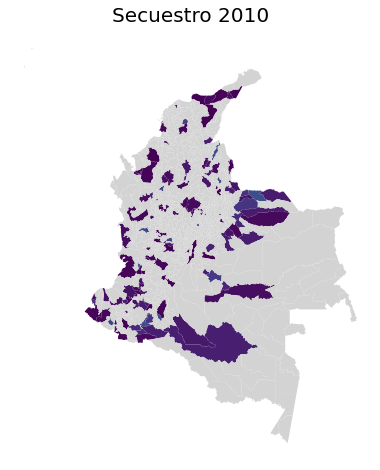

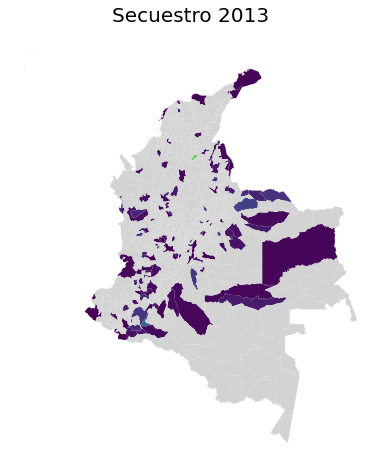

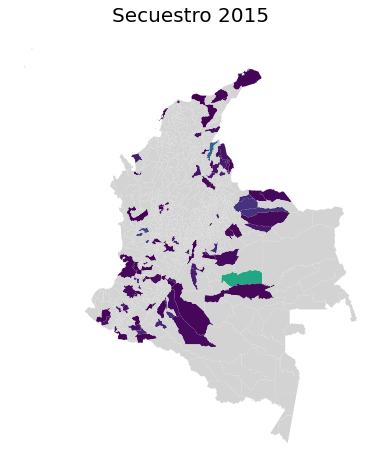

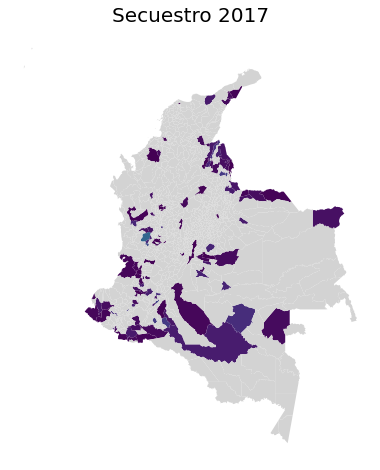

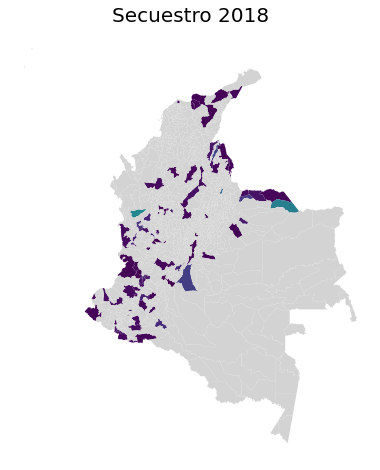

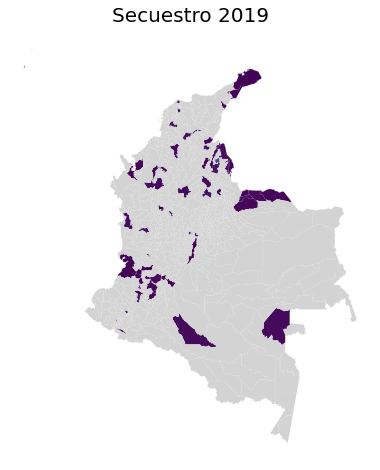

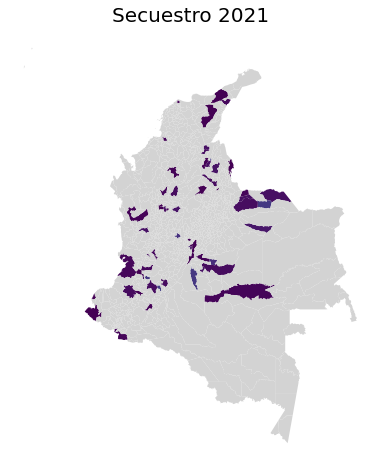

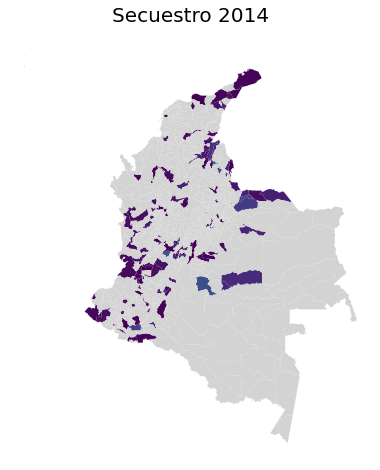

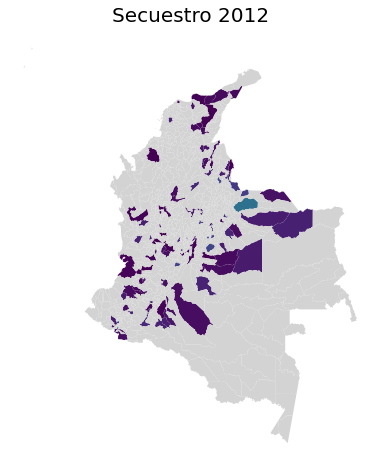

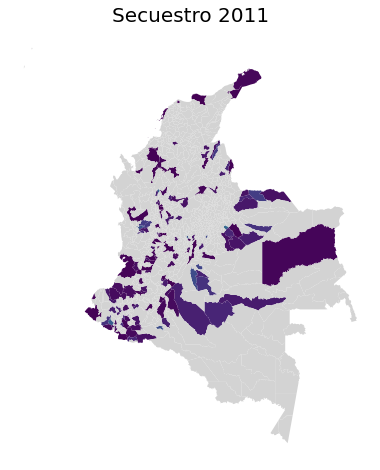

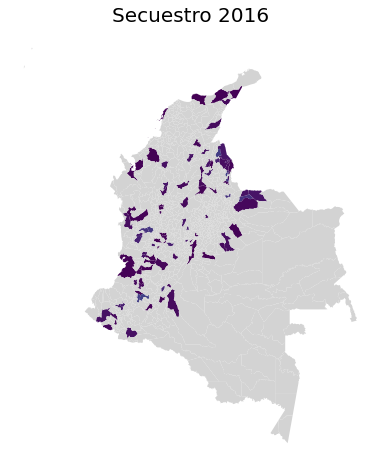

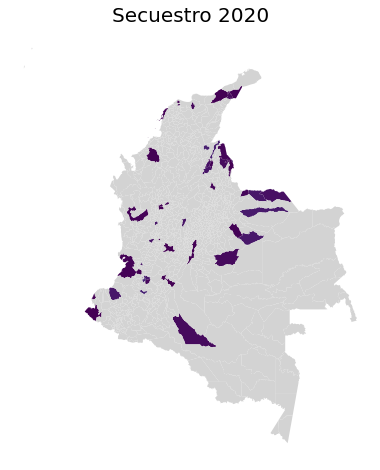

In [83]:
for fecha in geo_terr_not_na['fecha_año'].unique():
  geo_pas = geo_terr[geo_terr['fecha_año'] == fecha]

  fig, ax = plt.subplots(1, 1, figsize=(14, 8))
  geo_pas.plot('tasa_secuestro', 
               figsize=(14, 8), 
               missing_kwds=dict(color = "lightgrey"),
               ax=ax, vmin=terr_min, vmax=terr_max)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.set_title(f'Secuestro {int(fecha)}', size=20)
  plt.tick_params(left = False, bottom = False)
  ax.set_xticks([])
  ax.set_yticks([])
  fig.savefig(f'secuestro{int(fecha)}.png')
  plt.show()

## Gif

In [84]:
imgs = [re.findall('^s\w+\.png', i)[0] for i in os.listdir() if len(re.findall('^s\w+\.png', i))>0 ]

imgs = sorted(imgs)
with imageio.get_writer('my_gif.gif', mode='I', fps=0.8) as writer:
  for filename in imgs:
    image = imageio.imread(filename)
    writer.append_data(image)

In [82]:
num_terr.to_csv('secuestro.csv', index=False)